# Approximation of Logistic curve

First chunk of code generates approximation of logistic curve, starting by using step function to approximate the logistic curve with the width of each step determining the rate of movement between boxes. The step function is found iteratively with each iteration, given a set of values of step height, the time of step transition that minimze the spuared error is found, and with the optimized timestep, the optimal value of step height is found. This is repeated for 1000 times where stationary point is typically reached. The step function is conditioned so that the last step always have a height of one and the first step starts at t = 0. Given the rate of transition between boxes, the infectivity within each box is optimized in a way that the infectivity increases monotonically between 0 and 1.  

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as intg
import scipy.optimize as opt
import numexpr as ne
import numpy.random as rnd
import time

In [16]:
# number of boxes to approximate
nclass = 6
# logit = ll/(1 + exp(-k(x - x0))
k = 0.015
ll = 1
x0 = 150
numOpt = 2

[0.09534946 0.2        0.4        0.6        0.8        1.        ]
[0.09534946 0.2716618  0.47601168 0.68309834 0.86833244 1.        ]
[  0.          50.48169044 115.61387015 171.39646296 232.72465848
 326.83475521]


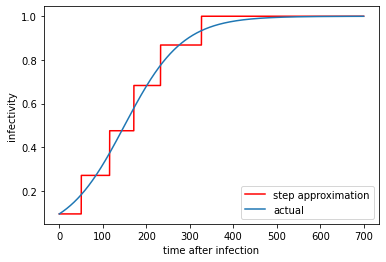

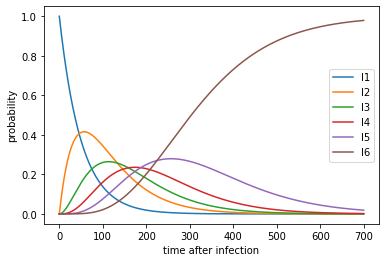

i=0: f=0.08 
i=1: f=0.32 
After 2, f=0.08 
[0.11863731523801936, 0.1186375661177919, 0.11863767993040687, 0.8688479364231446, 0.9999999999861771]
[0.019809162317070205, 0.015353393737807886, 0.017926739320808682, 0.01630571373338739, 0.010625852430283978]
[50.48169044 65.1321797  55.78259281 61.32819552 94.11009673]
0.0785457159382479


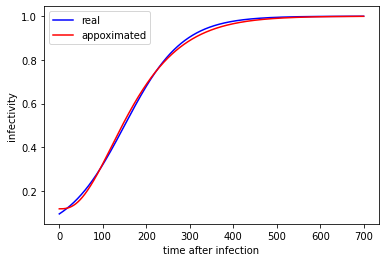

1.580234638734013
[0.11863732 0.11863757 0.11863768 0.86884794 1.         1.        ]


In [17]:
def logit(x, X0=x0, K=k, L=ll):
    return L/(1+np.exp(-K*(x-X0)))


def inverselogit(y, X0 = x0, K = k, L = ll):
    a = -1/K
    b = L/y - 1
    b = np.log(b)
    return a*b+X0


def approx(x, ts, ys):
    if x > ts[-1]:
        return ys[-1]
    elif x < 0:
        return 0
    else:
        which = np.argmax(ts > x)
        return ys[which-1]


def lost(x, args):
    ts = args[0:nclass]
    ys = args[nclass:2*nclass]
    return np.abs(approx(x, ts, ys) - logit(x))


def delta(nts, nys, ts, ys):
    a = np.append(nts, nys)
    b = np.append(ts, ys)
    return intg.quad(lost, 0, 1000, a) - intg.quad(lost, 0, 1000, b)


yvalues = np.array(range(nclass))/(nclass-1) * ll
yvalues2 = np.array(range(nclass))/(nclass-1) * ll
yvalues[0] = logit(0)
tvalues = np.zeros(nclass)
a = 0
print(yvalues)
while a < 1000:

    for i in range(1, nclass):
        tvalues[i] = inverselogit((yvalues[i-1]+yvalues[i])/2)
    for i in range(1, nclass-1):
        yvalues[i], err = intg.quad(logit, tvalues[i], tvalues[i+1]) / (tvalues[i+1]-tvalues[i])
    a += 1
    # if delta(newtvalues,newyvalues,tvalues,yvalues) < 0:
    #    tvalues = np.array(newtvalues)
    #    yvalues = np.array(newyvalues)
    # else:
    #     opt = False
print(yvalues)
print(tvalues)




times = np.array(range(7000))/10
app = []
logi = []
app2 = []
for t in times:
    app.append(approx(t, tvalues, yvalues))
    logi.append(logit(t))

plt.plot(times, app, color='r')
plt.xlabel("time after infection")
plt.ylabel("infectivity")
plt.plot(times, logi)
plt.legend(["step approximation", "actual"])
#plt.plot(times, app2, color="r")
#plt.savefig('step approx 2.png')
plt.show()



def link1(x):
    if x > 0:
        return x+1
    else:
        return np.exp(x)


def inverselink1(x):
    if x > 1:
        return x-1
    else:
        return np.log(x)


def coeff(i, n, rates):
    if i == 1 and n == 1:
        return 1
    elif i < n:
        a = rates[n-2]/(rates[n-1] - rates[i-1])
        return a*coeff(i, n-1, rates)
    elif i == n:
        a = 0
        for k in range(1, n):
            a += coeff(k, n-1, rates)/(rates[n-1]-rates[k-1])
        a *= -rates[n-2]
        return a


def link(s):
    q = []
    for i in range(len(s)):
        q.append(link1(s[i]))
    q = np.cumsum(q)
    b = []
    for i in range(len(s)):
        b.append(logit(inverselink1(q[i]), 0, 1))
    return b


def I(rates, n, t):
    if n < (len(rates)+1):
        a = 0
        for i in range(n):
            a += coeff(i+1, n, rates)*np.exp(-rates[i]*t)
        return a
    elif n == (len(rates)+1):
        a = 1
        for i in range(n):
            a -= I(rates, i, t)
        return a


def theta(beta, rates, t):
    a = 0
    for i in range(len(rates)+1):
        a += beta[i]*I(rates, i+1, t)
    return a

rate = []
for i in range(nclass-1):
    rate.append(1/(tvalues[i+1]-tvalues[i]))


plot = np.zeros([nclass, len(times)])

legends = []
for i in range(nclass):
    legends.append("I" + str(i+1))

for t in range(len(times)):
    for n in range(nclass):
        plot[n, t] = I(rate, n + 1, times[t])
for n in range(nclass):
    plt.plot(times, plot[n, :])
plt.ylabel("probability")
plt.xlabel("time after infection")
plt.legend(legends)
#plt.savefig('state in 2boxes.png')
plt.show()


def lostt(t, beta, rate = rate):
    a = theta(beta, rate, t) - logit(t)
    return a**2


def deltaa(beta):
    ii, error = intg.quad(lostt, 0, 1441, beta)
    # print(ii)
    return ii


def foropt(beta):
    beta = link(beta)
    beta.append(1)
    return deltaa(beta)



foundOpt = False

for i in range(numOpt):
    vstart = np.random.standard_cauchy(nclass - 1)
    w = opt.minimize(fun=foropt, x0=vstart)
    if w.success:
        # Report to screen
        print(f"i={i}: f={w.fun:.2f} ")
        # store if is best optimum so far (and flag that one been found)
        if foundOpt:
            if w.fun < bestF:
                bestF = w.fun
                bestX = w.x
                if bestF < 0.00001:
                    break
        else:
            bestF = w.fun
            bestX = w.x
            foundOpt = True
if foundOpt:
    print(f"After {numOpt}, f={bestF:.2f} ")
else:
    print(f"Didn't converge in {numOpt} attempts")

print(link(bestX))
print(rate)
print(1/np.array(rate))
times = np.arange(0, 700, 0.1)
the = []
lo = []
loo = []
thet = []
betas = link(bestX)
betas.append(1)
for t in times:
    lo.append(logit(t, 160, 0.0125, 1))
    loo.append(logit(t))
    the.append(theta(betas, rate, t))
    thet.append(theta(yvalues, rate, t))


plt.plot(times, loo, color = 'b')
plt.plot(times, the, color='r')
plt.xlabel("time after infection")
plt.ylabel("infectivity")
plt.legend(["real", "appoximated"])
# plt.plot(times, thet, color="g")
print(bestF)
#plt.savefig('fitted approx 2.png')
plt.show()
print(deltaa(yvalues))
#np.savetxt("variable width rates.csv", rate)
#np.savetxt("variable width betas.csv", betas)
rates = np.array(rate)
scale = np.array(betas)
print(scale)

Below is a search of various combination of number of classes and the value of $k * \mu$. Since it can be shown that for all logistic curves $y = L/(1 - exp(-k * (x - \mu))$ the optimal fit are easily convertable (see pdf approx of logit in the same repository), we can test the goodness of fit using the above method across different parameters. This takes a long time to run.

In [19]:
max_nclass = 6
kmu_values = np.arange(0.2, 10, 0.2)

SyntaxError: invalid syntax (Temp/ipykernel_16748/1787390197.py, line 2)

In [18]:
ll = 1
bestfs = np.zeros([max_nclass - 1, len(kmu_values)])
for iii in range(50):
    for jjj in range(max_nclass - 1):
        timetointto = 1000
        nclass = jjj + 2
        c = kmu_values[iii]
        x0 = 1000*c/(c + 8)
        k = c/x0


        def logit(x, X0=x0, K=k, L=ll):
            return L/(1+np.exp(-K*(x-X0)))


        def inverselogit(y, X0 = x0, K = k, L = ll):
            a = -1/K
            b = L/y - 1
            b = np.log(b)
            return a*b+X0


        def approx(x, ts, ys):
            if x > ts[-1]:
                return ys[-1]
            elif x < 0:
                return 0
            else:
                which = np.argmax(ts > x)
                return ys[which-1]


        def lost(x, args):
            ts = args[0:nclass]
            ys = args[nclass:2*nclass]
            return np.abs(approx(x, ts, ys) - logit(x))


        def delta(nts, nys, ts, ys):
            a = np.append(nts, nys)
            b = np.append(ts, ys)
            return intg.quad(lost, 0, 1000, a) - intg.quad(lost, 0, 1000, b)


        yvalues = np.array(range(nclass))/(nclass-1) * ll
        yvalues[0] = logit(0)
        tvalues = np.zeros(nclass)
        a = 0
        while a < 1000:

            for i in range(1, nclass):
                tvalues[i] = inverselogit((yvalues[i-1]+yvalues[i])/2)
            for i in range(1, nclass-1):
                yvalues[i], err = intg.quad(logit, tvalues[i], tvalues[i+1]) / (tvalues[i+1]-tvalues[i])
            a += 1


        def link1(x):
            if x > 0:
                return x+1
            else:
                return np.exp(x)


        def inverselink1(x):
            if x > 1:
                return x-1
            else:
                return np.log(x)


        def coeff(i, n, rates):
            if i == 1 and n == 1:
                return 1
            elif i < n:
                a = rates[n-2]/(rates[n-1] - rates[i-1])
                return a*coeff(i, n-1, rates)
            elif i == n:
                a = 0
                for k in range(1, n):
                    a += coeff(k, n-1, rates)/(rates[n-1]-rates[k-1])
                a *= -rates[n-2]
                return a


        def link(s):
            q = []
            for i in range(len(s)):
                q.append(link1(s[i]))
            q = np.cumsum(q)
            b = []
            for i in range(len(s)):
                b.append(logit(inverselink1(q[i]), 0, 1))
            return b


        def I(rates, n, t):
            if n < (len(rates)+1):
                a = 0
                for i in range(n):
                    a += coeff(i+1, n, rates)*np.exp(-rates[i]*t)
                return a
            elif n == (len(rates)+1):
                a = 1
                for i in range(n):
                    a -= I(rates, i, t)
                return a


        def theta(beta, rates, t):
            a = 0
            for i in range(len(rates)+1):
                a += beta[i]*I(rates, i+1, t)
            return a

        rate = []
        for i in range(nclass-1):
            rate.append(1/(tvalues[i+1]-tvalues[i]))


        def lostt(t, beta, rate = rate):
            a = theta(beta, rate, t) - logit(t)
            return a**2


        def deltaa(beta):
            ii, error = intg.quad(lostt, 0, 1000, beta)
            return ii


        def foropt(beta):
            beta = link(beta)
            beta.append(1)
            return deltaa(beta)


        numOpt = 10
        foundOpt = False

        for i in range(numOpt):
            vstart = np.random.standard_cauchy(nclass - 1)
            w = opt.minimize(fun=foropt, x0=vstart)
            if w.success:
                # Report to screen
                #print(f"i={i}: f={w.fun:.2f} ")
                # store if is best optimum so far (and flag that one been found)
                if foundOpt:
                    if w.fun < bestF:
                        bestF = w.fun
                        bestX = w.x
                        if bestF < 0.00001:
                            break
                else:
                    bestF = w.fun
                    bestX = w.x
                    foundOpt = True
        if foundOpt:
            print(f"After {numOpt}, f={bestF:.2f} ")
        else:
            print(f"Didn't converge in {numOpt} attempts")

        bestfs[jjj, iii] = bestF




NameError: name 'max_nclass' is not defined

In [49]:
legends = []
for i in range(2, max_nclass + 1):
    legends.append(str(i) + " boxes")
plt.plot(kmu_values, bestfs.T)
plt.xlabel('k*mu')
plt.ylabel('squared deviation')
plt.legend(legends)
plt.show()
plt.plot(kmu_values, np.log(bestfs.T))
plt.xlabel('k*mu')
plt.ylabel('log(squared deviation)')
plt.legend(legends)
plt.show()
bestfs2 = betfs / bestfs[:, 1]
plt.plot(kmu_values, np.log(besfs2))
plt.show()

NameError: name 'max_nclass' is not defined

Once we have a set of rate and infectivity between boxes, we can simulate gradual change in infectivity. For abrupt change of infectivity of which latent period does not follows the logistic distribution, or both abrupt and gradual change of probability of detection, see the other jupyter notebook titled "different culling radius".  The below code uses the scale and rate of transition from the first chunk of code.

In [14]:
# here we set the survey internal in the detection scheme
survey_interval = 90
#set the parameter for the model, mu and k is set earlier.
beta = 5.25
alpha = 37
# set  the end of simulation
tend = 1440

0


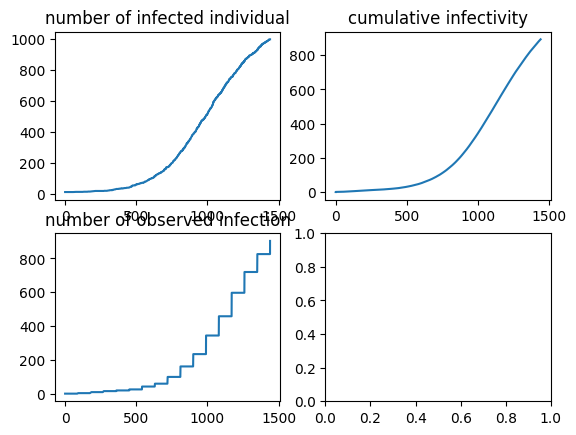

In [15]:
b = scale * beta
b = np.append(np.array([0]), b)
m = b.shape[0]
sigma = np.append(rates, np.array([0]))
sigma = np.append(np.array([0]), sigma)

a = alpha
num_tree = 1111
tre = np.loadtxt("smallLandscape.txt")

# here we set the likelihood of detection which can (but not in this case) be a different logistic curve compared to the infectivity.
def logit(x, mu=130, k=0.02):
    return 1/(1 + np.exp(-k * (x - mu)))


def inverselogit(y, mu=130, k=0.02, l=1):
            a = -1/k
            b = l/y - 1
            b = np.log(b)
            return a*b+mu


# dispersal kernel
def dispersal(alpha):
    dis = ne.evaluate("1/(1+(distance/alpha)**2)")
    factor = (np.sum(dis) - 1111) / 2
    dis = ne.evaluate('dis/factor')
    return dis


# pairwise distance matrix
distance = np.zeros([num_tree, num_tree])
for i in range(num_tree):
    for j in range(num_tree):
        distance[i, j] = ((tre[i, 0] - tre[j, 0]) ** 2 + (tre[i, 1] - tre[j, 1]) ** 2) ** 0.5

dispersing = dispersal(a)
dispersing[dispersing < 1e-10] = 0
fig, axs = plt.subplots(2,2)
axs[0,0].set_title("number of infected individual")
axs[0, 1].set_title("cumulative infectivity")
axs[1, 0].set_title("number of observed infection")
# LOOP START
# The model structure is similar to the other models in "different cull radius". the detection scheme is that of gradual change in probability
# here q decides the number of replicates.
for q in range(1):
    print(q)
    ts = [0]
    Ss = [1101]
    Is = [10]
    Infs = [0]
    Obs = [0]
    t = 0
    tree = np.c_[tre, np.zeros(num_tree), np.zeros(num_tree), np.zeros(num_tree), np.zeros(num_tree)]
    initial = rnd.randint(0, num_tree, 10)
    tree[initial, 2] = 1
    tree[initial, 3] = sigma[1]
    # setting initial pressure
    for i in initial:
        for j in np.where(tree[:, 2] == 0)[0]:
            tree[j, 3] += b[1] * dispersing[i, j]
    # loops
    while t < tend:
        # infection
        event = np.cumsum(tree[:, 3])
        time_to_survey = survey_interval - (t % survey_interval)
        rate = event[-1]
        if rate > 0:
            timestep = rnd.exponential(1 / rate)
        else:
            break
        if timestep > time_to_survey:
            p_detected = np.zeros(1111)
            can_detect = np.logical_and(tree[:, 2] > 0, tree[:, 5] == 0)
            p_detected[can_detect] = logit(t + time_to_survey - tree[can_detect, 4])
            survey = np.random.uniform(0, 1, 1111)
            detected = p_detected > survey
            tree[detected, 5] = t + time_to_survey
        t += timestep
        ts.append(t)
        whichevent = rate * rnd.rand()
        which = np.argmax(event > whichevent)
        tree[which, 2] += 1
        state = int(tree[which, 2])
        if state == 1:
            tree[which, 4] = t
        tree[which, 3] = sigma[state]
        db = b[state] - b[state - 1]
        for i in np.where(tree[:, 2] == 0)[0]:
            tree[i, 3] += db * dispersing[which, i]
        Ss.append(sum(tree[:, 2] == 0))
        Is.append(sum(tree[:, 2] > 0))
        Obs.append(sum(tree[:, 5] > 0))
        Infs.append(sum(logit(t - tree[tree[:,2] > 0, 4])))
    #    plt.scatter(tree[tree[:,2]==0,0],tree[tree[:,2]==0,1])
    #    plt.scatter(tree[tree[:,2]==1,0],tree[tree[:,2]==1,1])
    #    plt.scatter(tree[tree[:,2]==2,0],tree[tree[:,2]==2,1])
    #    plt.scatter(tree[tree[:,2]==3,0],tree[tree[:,2]==3,1])
    #    plt.title(t)
    #    plt.show()
    axs[0,0].plot(ts, Is)
    axs[0, 1].plot(ts, Infs)
    axs[1, 0].plot(ts, Obs)

plt.show()
data = tree

To recover the parameters, we need to first write down the likelihood function. It follows the form of:

\begin{align}
\prod_{i \in I(t_{end})} \phi_i(t_i^E) e^{ -\int_{0}^{t_i^E} \phi_i(u) du}f(t_i^{detect} - t_i^E) \prod_{t \in \mathbb{S}, \, t_i^{detect} >t > t_i^E} (1 - f(t - t_i^E)) \\
 * \prod_{i \in E(t_{end})} \phi_i(t_i^E) e^{ -\int_{0}^{t_i^E} \phi_i(u) du} \prod_{t \in \mathbb{S}, \, t_{end} >t > t_i^E} (1 - f(t - t_i^E)) \\
 * \prod_{i \in S(t_{end})} \phi_i(t_{end}) e^{ -\int_{0}^{t_{end}} \phi_i(u) du}
\end{align}

Where $\phi_i(t)$ is the infectious pressure on individual i at time t, $I(t)$ the set of individuals that are diagnosed as infected at time t, $E(t)$ thoes infected but not diagnosed, $S(t)$ not infected, $\mathbb{S}$ the surveying times, $t_i^E$ the time of infection of the ith individual, $t_i^{detect}$ the time it is detected, and $f(t)$ the probability of detection at time t after infection. In our case we have
$f(x)= \frac{1}{1 + e^{-k(x - \mu)}} $ and $\phi_i(t) = \sum_{j \in I(t)} \beta f(t - t_j^E) K(d_{ij}, \alpha)$ where $\beta$ is the assymptotic infectivity of infected individual, $K(d_{ij},\alpha)$ is the dispersal kernel given the disrance $d_{ij}$ between trees and $\alpha$ the shape parameter. It is thus possible to write codes for likelihood functions:

In [7]:
def logit(x, mu, k):
    return ne.evaluate('1/(1 + exp(-k * (x - mu)))')


# used on calculation with smaller size
def logit2(x, mu, k):
    return 1 / (1+np.exp(-k * (x - mu)))


#though it is possible to cut down the number of exp used in this function, it is desirable for exp(-...) to prevent overflow.
def intlogit(t, mu, k):
    return ne.evaluate('log((exp(-k * (t-mu)) + 1)/(exp(-k * t) + exp(-k * (t-mu))))')
    

def dispersal(alpha):
    dis = ne.evaluate("1/(1+(distance/alpha)**2)")
    factor = (np.sum(dis) - 1111) / 2
    dis = ne.evaluate('dis/factor')
    dis[dis < 1e-10] = 0
    return dis


def vphi(time_to_eval, mu, k, b, kernel, whichtree, time_of_infection, usedata):
    infect = np.array([time_of_infection, ])
    eva = np.array([time_to_eval, ]).T
    subtracted = eva - infect
    subtracted[subtracted < 0] = 0
    subtracted[:, usedata[:, 2] == 0] = 0
    # now subtracted is a matrix where columns represent source of propagules, row represent trees,
    # and subtracted[i, j] is the time since infection of the source
    logits = b * logit(subtracted, mu, k)
    logits[subtracted == 0] = 0
    truncated_kernel = kernel[whichtree, :]
    results = ne.evaluate('logits*truncated_kernel')
    return np.sum(results, axis=1)


def vintphi(t_to_int_to, mu, k, beta, kernel, whichtree, time_infected, usedata):
    infected = np.array([time_infected, ])
    eva = np.array([t_to_int_to, ]).T
    subtracted = eva - infected
    subtracted[subtracted < 0] = 0
    subtracted[:, usedata[:, 2] == 0] = 0
    ints = intlogit(subtracted, mu, k)
    ints[subtracted == 0] = 0
    truncated_kernel = kernel[whichtree, :]
    results = ne.evaluate('ints*truncated_kernel')
    return beta * np.sum(results, axis=1) / k


def notfoundgiventime(surveyed_time, infected_time, survey_interval, mu, k):
    qq = surveyed_time.copy()
    notfound = surveyed_time > infected_time
    if np.any(notfound):
        qq[notfound] = np.log(1 - logit2(surveyed_time[notfound] - infected_time[notfound], mu, k)) + notfoundgiventime(surveyed_time[notfound] - survey_interval, infected_time[notfound], survey_interval, mu, k)
    other = surveyed_time <= infected_time
    qq[other] = 0
    return qq


# it is important to note that the kernel instead of alpha is used as input
def likelihood(usedata, mu, k, beta, kernel, survey_interval=survey_interval):
    qq = np.zeros(1111)
    intto = np.repeat(tend, int(np.sum(usedata[:, 2] == 0)))
    qq[usedata[:, 2] == 0] = -vintphi(intto, mu, k, beta, kernel, usedata[:, 2] == 0, usedata[:, 4], usedata)
    da_trees = np.logical_and(usedata[:, 2] > 0, usedata[:, 4] > np.min(usedata[usedata[:, 2] > 0, 4]))
    qq[da_trees] = -vintphi(usedata[da_trees, 4], mu, k, beta, kernel, da_trees, usedata[:, 4], usedata)
    qq[da_trees] = qq[da_trees] + np.log(vphi(usedata[da_trees, 4], mu, k, beta, kernel, da_trees, usedata[:, 4], usedata))
    etrees = np.logical_and(usedata[:, 2] > 0, usedata[:, 5] == 0)
    itrees = np.logical_and(usedata[:, 2] > 0, usedata[:, 5] > 0)
    ww = np.repeat(tend, int(np.sum(etrees)))
    qq[etrees] = qq[etrees] + notfoundgiventime(ww, usedata[etrees, 4], survey_interval, mu, k)
    qq[itrees] = qq[itrees] + np.log(logit2(usedata[itrees, 5] - usedata[itrees, 4], mu, k))
    qq[itrees] = qq[itrees] + notfoundgiventime(usedata[itrees, 5] - survey_interval, usedata[itrees, 4], survey_interval, mu, k)
    return qq


# equiv. to uniform prior, with all parameters > 0
def prior(mu, k, beta, a):
    if mu < 0 or k < 0 or beta < 0 or a < 0:
        return -np.infty
    else:
        return 0


Using the full data we can verify that the parameter can be recovered with mcmc.

700.8473160266876


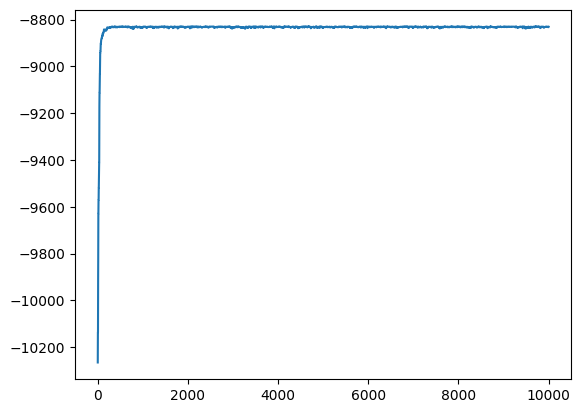

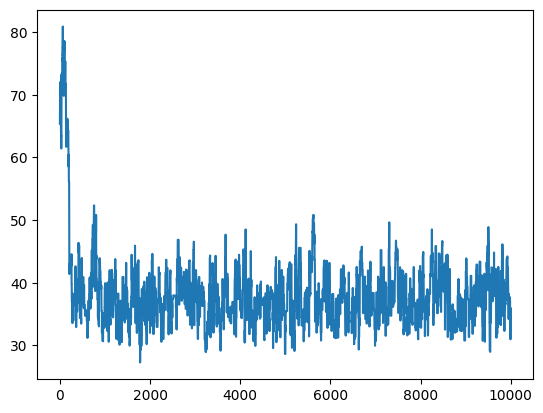

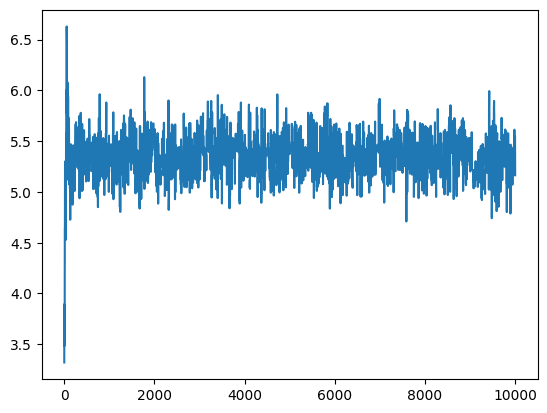

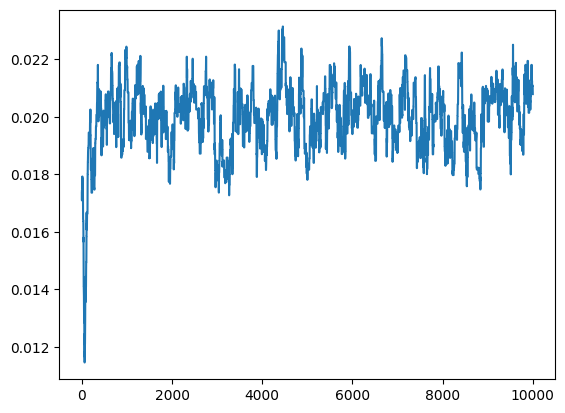

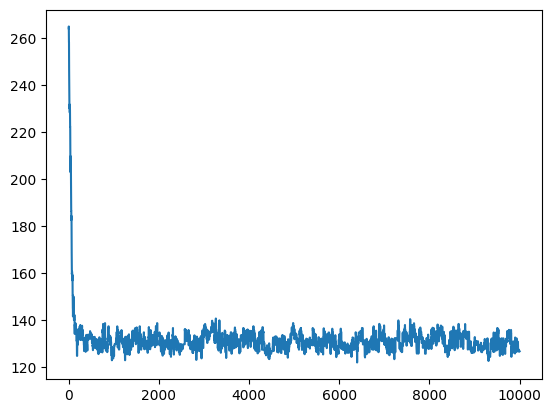

In [13]:
# 1 iteration ~0.07s on office computer, 10000 should be enough
num_run = 10000
current = -np.infty
while current == -np.inf:
    m = np.random.uniform(0, 300)
    k = np.random.uniform(0, 0.1)
    b = np.random.uniform(0, 10)
    a = np.random.uniform(0, 100)
    kern = dispersal(a)
    current = np.sum(likelihood(data, m, k, b, kern, survey_interval)) + prior(m, k, b, a)
ass = np.zeros(num_run + 1)
bss = np.zeros(num_run + 1)
kss = np.zeros(num_run + 1)
mss = np.zeros(num_run + 1)
currents = np.zeros(num_run + 1)
ass[0] = a
bss[0] = b
kss[0] = k
mss[0] = m
currents[0] = current
st = time.time()
for t in range(num_run):
    nm = m + np.random.normal(0, 4)
    nk = k + np.random.normal(0, 0.0005)
    nb = b + np.random.normal(0, 0.5)
    na = a + np.random.normal(0, 3)
    nkern = dispersal(na)
    change = np.random.uniform()
    new = np.sum(likelihood(data, nm, nk, nb, nkern, survey_interval)) + prior(nm, nk, nb, na)
    prob_change = np.exp(new - current)
    if change < prob_change:
        m = nm
        k = nk
        b = nb
        a = na
        kern = nkern.copy()
        current = new
    ass[t + 1] = a
    bss[t + 1] = b
    kss[t + 1] = k
    mss[t + 1] = m
    currents[t + 1] = current
et = time.time()
print(et - st)
plt.plot(currents)
plt.show()
plt.plot(ass)
plt.show()
plt.plot(bss)
plt.show()
plt.plot(kss)
plt.show()
plt.plot(mss)
plt.show()

To find the mode, first define a kernel density estimate:

In [16]:
sampled = np.arange(int(num_run/10), len(ass), 500)
def kde_for_opt(parms, aa = ass[sampled], bb = bss[sampled], kk = kss[sampled], mm = mss[sampled]):
    # width are chosen so that all are on the same order of magnitude
    da = (parms[0] - aa) / 8
    db = parms[1] - bb
    # devide by 100 first so that the optimized value is ~1-10, which decrease the chance of divergent
    # since the step take by the optimizer is often too large
    dk = (parms[2] / 100 - kk) * 1000
    dm = (parms[3] - mm) / 30
    # normalizing factor is ommited since we only need to find the mode and not the actual distribution
    # gaussian kernel is used
    kde = np.exp(-(da**2 + db**2 + dk**2 + dm**2))
    return -np.sum(kde)

NameError: name 'num_run' is not defined

In [16]:
numOpt = 1000
foundOpt = False
print(numOpt)
for i in range(numOpt):
    vstart = np.random.uniform(np.array([np.min(ass), np.min(bss), np.min(kss) * 100, np.min(mss)]), np.array([np.max(ass), np.max(bss), 100*np.max(kss), np.max(mss)]))
    w = opt.minimize(fun=kde_for_opt, x0=vstart)
    if w.success:
        # Report to screen
        #print(f"i={i}: f={w.fun:.2f} ")
        # store if is the best optimum so far (and flag that one been found)
        if foundOpt:
            if w.fun < bestF:
                bestF = w.fun
                bestX = w.x
        else:
            bestF = w.fun
            bestX = w.x
            foundOpt = True
if foundOpt:
    print(f"After {numOpt}, f={bestF} ")
else:
    print(f"Didn't converge in {numOpt} attempts")
print("a = ", bestX[0], ", b = ", bestX[1], ", k = ", bestX[2]/100, "mu = ", bestX[3])

1000
After 1000, f=-7.447028789507321 
a =  35.93859712697154 , b =  5.454629295866826 , k =  0.019275981445017652 mu =  132.75920348489575


Compare the result to estimates using likelihood function of box models: ( in this case since there are not transition time from E to I, the likelihood function like that in the paper can only be used with data augmentation, with transition time estimated as some value between two surveys.)
Note that the time of diagnosis is effected by the survey interval. As survey interval approaches 0, the time of diagnosis will approach time of infection. This is distinct from the model assumption of the simple SEI model where the time of identification is essentially an exponentially distributed variable X rounded up to the closest multiple of surveying interval. Therefore the estimate of parameter using this likelihood function will be influeced by the surveying interval, where the above one will not because the surveying interval is considered in the likelihood function. 

In [ ]:
# extract data in a way that is compatible with the function
# each iteration, involving proposal of all time from S->E with state changes, proposal of one time from E -> I, and change in parameter
# takes 0.09s per iteration on office computer
survey = survey_interval
# change the data to mimick real survey data
data2 = data.copy()
data2[:, 4] = 0
itrees = np.logical_and(data2[:, 2] > 0, data2[:, 5] > 0)
data2[itrees, 2] = 2
data2[np.logical_not(itrees), 2] = 0
nonI = []
areI = []
for i in range(1111):
    if data2[i, 2] != 2:
        nonI.append(i)
    else:
        areI.append(i)
notI = len(nonI)


def genrd(state, ti):
    ub = np.zeros(1111)
    lb = np.zeros(1111)
    lb[:] = np.min(ti[state == 2])
    lb[np.where(ti == lb[1])] = 0
    lb[state == 0] = 0
    ub[state == 2] = ti[state == 2]
    ub[state == 1] = tend
    return np.random.uniform(lb, ub)


def dispersal(a):
    dis = ne.evaluate("1/(1+(distance/a)**2)")
    factor = (np.sum(dis) - 1111)/2
    dis = ne.evaluate('dis/factor')
    return dis


def vphiexp(ts, i, kernel, ti, state):
    infect = np.array([ti, ])
    eva = np.array([ts, ]).T
    subtracted = eva > infect
    subtracted[:, state != 2] = False
    trunc_kern = kernel[i, :]
    result = ne.evaluate('subtracted*trunc_kern')
    return np.sum(result, axis=1)


def vintphiexp(ts, i, kernel, ti, state):
    infect = np.array([ti, ])
    eva = np.array([ts, ]).T
    subtracted = infect - eva
    subtracted[subtracted > 0] = 0
    subtracted[:, state != 2] = 0
    trunc_kern = kernel[i, :]
    result = ne.evaluate('subtracted*trunc_kern')
    return np.sum(result, axis=1)


def loglikelihoodexp(b, kernel, sigma, te, state, tii):
    tee = te.copy()
    tee[state == 0] = tend
    goodtrees = tee > np.min(tii[state == 2])
    qq = np.zeros(1111)
    # add the intphi portion
    qq[goodtrees] = b * vintphiexp(tee[goodtrees], goodtrees, kernel, tii, state)
    # add the phi portion, only to E and I trees
    goodtrees2 = np.logical_and(state > 0, goodtrees)
    qq[goodtrees2] = qq[goodtrees2] + np.log(b * vphiexp(te[goodtrees2], goodtrees2, kernel, tii, state))
    # add times spent in E
    qq[state == 1] = qq[state == 1] - sigma * (tend - te[state == 1])
    qq[state == 2] = qq[state == 2] - sigma * (tii[state == 2] - te[state == 2]) + np.log(sigma)
    return qq



def prior(b, a, sigma):
    if a < 0 or b < 0 or sigma < 0 or a > 1e3 or b > 1e3:
        return np.log(0)
    else:
        return np.log(107) - 107*sigma



a = np.random.uniform(100)
kern = dispersal(a)
b = np.random.uniform(10)
s = np.random.uniform(300)
ti = np.zeros(1111)
ti[areI] = np.random.uniform(data2[areI, 5] - survey, data2[areI, 5])
tend = np.max(ti)
ltn = np.log(tend)
cstate = data2[:, 2].copy()
cstate[nonI] = np.random.binomial(1, 0.5, len(nonI))
bb = genrd(cstate, ti)
current = loglikelihoodexp(b, kern, 1/s, bb, cstate, ti)
sumcurrent = np.sum(current)
a2ss = [a]
b2ss = [b]
s2ss = [s]
t2ss = [0]
current2ss = [sumcurrent]
current_with_parm = sumcurrent + prior(b, a, 1/s)
st = time.time()
for i in range(1000000):
    current2ss.append(sum(current))
    # changing times (hidden parms)
    nstate = cstate.copy()
    totalstatechange = np.zeros(1111, dtype=bool)
    totalstatechange[nonI] = np.random.binomial(1, 0.5, notI)
    # if statechange is 0, we do not change state, but rather propose a new time (or not)
    # if statechange is 1, we change the state.
    nstate[totalstatechange] = 1 - nstate[totalstatechange]
    nbb = genrd(nstate, ti)
    # whether acceppting each changes
    newfores = loglikelihoodexp(b, kern, 1/s, nbb, nstate, ti)
    # adding the factor to ensure detailed balance
    newfores2 = newfores.copy()
    newfores2[np.logical_and(nstate == 1, totalstatechange)] = newfores2[np.logical_and(nstate == 1, totalstatechange)] + ltn
    newfores2[np.logical_and(nstate == 0, totalstatechange)] = newfores2[np.logical_and(nstate == 0, totalstatechange)] - ltn
    changes = np.random.uniform(0, 1, 1111)
    tochange = changes < np.exp(newfores2 - current)
    cstate[tochange] = nstate[tochange].copy()
    current[tochange] = newfores[tochange].copy()
    bb[tochange] = nbb[tochange].copy()
    # change ti
    changeI = np.random.choice(areI, 1)
    lbforchangeI = np.array([data2[changeI, 5] - survey, bb[changeI]])
    changetoti = np.random.uniform(np.max(lbforchangeI), data2[changeI, 5])
    nti = ti.copy()
    nti[changeI] = changetoti
    newforti = loglikelihoodexp(b, kern, 1/s, bb, cstate, nti)
    changeI = np.random.uniform(1)
    whetherchange = np.exp(np.sum(newforti) - np.sum(current))
    if changeI < whetherchange:
        ti = nti.copy()
        current = newforti.copy()
        tend = np.max(ti)
        ltn = np.log(tend)
    # change real parms
    na = a + np.random.normal(0, 3)
    nkern = dispersal(na)
    nb = b + np.random.normal(0, 0.5)
    ns = s + np.random.normal(0, 3)
    new_1 = loglikelihoodexp(nb, nkern, 1/ns, bb, cstate, ti)
    current_with_parm = np.sum(current) + prior(b, a, 1/ns)
    new_with_parm = np.sum(new_1) + prior(nb, na, 1/ns)
    delta = np.random.uniform()
    if delta < np.exp(new_with_parm-current_with_parm):
        a = na
        b = nb
        s = ns
        kern = nkern.copy()
        a2ss.append(a)
        b2ss.append(b)
        s2ss.append(s)
        t2ss.append(i)
        current = new_1.copy()
    current2ss.append(np.sum(current))
et = time.time()
print(et - st)
print(cstate[nonI])

In [74]:
sample_interval = 5000
t2 = np.array(t2ss) % sample_interval
sampled = []
for i in range(len(t2ss) - 1):
    if t2[i + 1] < t2[i]:
        sampled.append(i)

sampled = sampled[int(len(sampled) / 10):-1]
sampled = np.array(sampled)
a2ss = np.array(a2ss)
b2ss = np.array(b2ss)
s2ss = np.array(s2ss)
def smoothed(parms, a = a2ss[sampled], b=b2ss[sampled], s=s2ss[sampled]):
    da = (parms[0] - a) / 6
    db = (parms[1] - b)
    ds = (parms[2] - s) / 10
    dist = da**2 + db **2 + ds **2
    return -np.sum(np.exp(-dist))


In [75]:
numOpt = 1000
foundOpt = False
print(numOpt)
for i in range(numOpt):
    vstart = np.random.uniform(np.array([np.min(a2ss), np.min(b2ss), np.min(s2ss)]), np.array([np.max(a2ss), np.max(b2ss),np.max(s2ss)]))
    w = opt.minimize(fun=smoothed, x0=vstart)
    if w.success:
        # Report to screen
        #print(f"i={i}: f={w.fun:.2f} ")
        # store if is the best optimum so far (and flag that one been found)
        if foundOpt:
            if w.fun < bestF:
                bestF = w.fun
                bestX = w.x
        else:
            bestF = w.fun
            bestX = w.x
            foundOpt = True
if foundOpt:
    print(f"After {numOpt}, f={bestF} ")
else:
    print(f"Didn't converge in {numOpt} attempts")
print("a = ", bestX[0], ", b = ", bestX[1], ", s = ", bestX[2])

1000
After 1000, f=-49.85097368123061 
a =  31.47229802238908 , b =  5.74868958318855 , s =  119.99062687882271


In [48]:
np.savetxt("C:\\Users\\wayne\\.vscode\\SIm data .csv", tree)

From a single realization, we can have an estimate of the parameters if the actual underlying dynamic is SEI model, We can then contrast the spread of disease with the actual epidemic.

In [ ]:
dispersing2 = dispersal(bestX[0])
dispersing2[dispersing2 < 1e-10] = 0
sigma2 = [0, 1/bestX[2], 0]
beta2 = [0, 0, bestX[1]]

In [ ]:
fig, axs = plt.subplots(2,2)
axs[0,0].set_title("number of infected individual")
axs[0, 1].set_title("cumulative infectivity")
axs[1, 0].set_title("number of observed infection")
axs[0,0].plot(ts, Is)
axs[0, 1].plot(ts, Infs)
axs[1, 0].plot(ts, Obs)
st = time.time()
for q in range(30):
    print(q)
    ts2 = [0]
    Ss2 = [1101]
    Is2 = [10]
    Obs2 = [0]
    Infs2 = [0]
    t = 0
    tree = np.c_[tre, np.zeros(num_tree), np.zeros(num_tree), np.zeros(num_tree), np.zeros(num_tree)]
    initial = rnd.randint(0, num_tree, 10)
    tree[initial, 2] = 1
    tree[initial, 3] = sigma2[1]
    # setting initial pressure
    notinf = np.where(tree[:, 2] == 0)
    for i in initial:
        tree[notinf, 3] = tree[notinf, 3] + beta2[1] * dispersing[notinf, i]
    # loops
    while t < tend:
        # infection
        event = np.cumsum(tree[:, 3])
        time_to_survey = survey_interval - (t % survey_interval)
        rate = event[-1]
        if rate > 0:
            timestep = rnd.exponential(1 / rate)
        else:
            break
        if timestep > time_to_survey:
            tree[tree[:, 2] == 2, 5] = t + time_to_survey
        t += timestep
        ts2.append(t)
        whichevent = rate * rnd.rand()
        which = np.argmax(event > whichevent)
        tree[which, 2] += 1
        state = int(tree[which, 2])
        if state == 1:
            tree[which, 4] = t
        tree[which, 3] = sigma2[state]
        db = beta2[state] - beta2[state - 1]
        notinf = np.where(tree[:, 2] == 0)[0]
        tree[notinf, 3] = tree[notinf, 3] + (db * dispersing[notinf, which])
        Ss2.append(sum(tree[:, 2] == 0))
        Is2.append(sum(tree[:, 2] > 0))
        Infs2.append(sum(logit(t - tree[tree[:, 2] > 0, 4])))
        Obs2.append(sum(tree[:, 5] > 0))
    #    plt.scatter(tree[tree[:,2]==0,0],tree[tree[:,2]==0,1])
    #    plt.scatter(tree[tree[:,2]==1,0],tree[tree[:,2]==1,1])
    #    plt.scatter(tree[tree[:,2]==2,0],tree[tree[:,2]==2,1])
    #    plt.scatter(tree[tree[:,2]==3,0],tree[tree[:,2]==3,1])
    #    plt.title(t)
    #    plt.show()
    axs[0,0].plot(ts2, Is2, lw=0.1, color='r')
    axs[0,1].plot(ts2, Infs2, lw=0.1, color='r')
    axs[1,0].plot(ts2, Obs2, lw=0.1, color='r')
et = time.time()
print(et - st)
plt.show()

It can be seen that when fitted to a simple SEI model, then plotted against the prediction from the simple model, the original curve seems to have a slower progression at the start and faster at the later stage of epidemic. Nevertheless, it is possible to fit a simpler model which behave more or less similar to the original more complex model. Even with the forward fitting approach, where the curve of infectivity is known and then a model made from the infectivity curve, simple box model is sufficient in capturing the epidemic progression when the actual disease progression is logistic. (see another jupyter notebook titled "forward fitting approach".)

As for fitting the logistic curve from epidemic data, I have made an algorithm based on the individual detection probability increases logistically (the same as above model), and the fit is moderately good, but the assumption that went in, which is that infectivity and detectability is perfectly linked, is unlikely to be the case. The MCMC algorithm will also be different if instead of a gradually increasing probability of detection, we have an abrupt change (p(detection) = 1 or 0), but the length of latent period so distributed that the probability of detection is still linked exactly with the infectivity, the form of likelihood function will be different, and when the wrong one is used, the resulted fitting is unreliable. Nevertheless, it is included below.  

In [ ]:
# this part loads the data from the simulation, and clean off the information about time of infection
# but only retain time of detection. So that the data looks like those observed from the field
# the data still needs to conform to the same format as other, that is, the first two column contain coordinates
# the third column contain state, with 2 being infected and detected, 1 being infected but not detected
# and 0 being not infected. In practice, since 0 and 1 is indistinguishable in the field, all 0 is fine, 
# and reversible jump state changes is used as part of the algorithm
# the fourth column is the time of infection, left as 0 is fine, and the fifth time of detection. 
# estimation of start of epidemic is not included, instead time 0 is defaulted as the start of epidemic.
# This should not be a great issue, since the first infected individual will have an augmented time of infection between 
# 0 and the first detection. This will be functionally the same as the parameter for the start of epidemic.

realdata = tree.copy()
data = realdata.copy()
data[np.logical_and(data[:, 2] > 0, data[:, 5] > 0), 2] = 2
data[np.logical_and(data[:, 2] > 0, data[:, 5] == 0), 2] = 1
data[:, 4] = 0
tend = np.max(data[:,5])
distance = np.zeros(shape=[1111, 1111])
for i in range(1111):
    for j in range(1111):
        distance[i, j] = ((data[i, 0] - data[j, 0]) ** 2 + (data[i, 1] - data[j, 1]) ** 2) ** 0.5
print(np.sum(data[:, 2] > 0))
notI = np.where(data[:, 2] < 2)[0]
isI = np.where(data[:, 2] == 2)[0]


def generate_random_infected_time(usedata):
    lowerbounds = np.zeros(1111)
    upperbounds = np.zeros(1111)
    upperbounds[usedata[:, 2] == 2] = usedata[usedata[:, 2] == 2, 5]
    upperbounds[usedata[:, 2] == 1] = tend
    infected_times = np.random.uniform(lowerbounds, upperbounds)
    usedata[:, 4] = infected_times
    return usedata


def logit(x, mu, k):
    return ne.evaluate('1/(1 + exp(-k * (x - mu)))')


def logit2(x, mu, k):
    return 1 / (1+np.exp(-k * (x - mu)))


# this function should be able to use t as a vector
def intlogit(t, mu, k):
    return ne.evaluate('log((exp(-k * (t-mu)) + 1)/(exp(-k * t) + exp(-k * (t-mu))))')


def dispersal(alpha):
    dis = ne.evaluate("1/(1+(distance/alpha)**2)")
    factor = (np.sum(dis) - 1111) / 2
    dis = ne.evaluate('dis/factor')
    dis[dis < 1e-10] = 0
    return dis


def vphi(time_to_eval, mu, k, b, kernel, whichtree, time_of_infection, usedata):
    infect = np.array([time_of_infection, ])
    eva = np.array([time_to_eval, ]).T
    subtracted = eva - infect
    subtracted[subtracted < 0] = 0
    subtracted[:, usedata[:, 2] == 0] = 0
    # now subtracted is a matrix where columns represent source of propagules, row represent trees,
    # and subtracted[i, j] is the time since infection of the source
    logits = b * logit(subtracted, mu, k)
    logits[subtracted == 0] = 0
    truncated_kernel = kernel[whichtree, :]
    results = ne.evaluate('logits*truncated_kernel')
    return np.sum(results, axis=1)


def vintphi(t_to_int_to, mu, k, beta, kernel, whichtree, time_infected, usedata):
    infected = np.array([time_infected, ])
    eva = np.array([t_to_int_to, ]).T
    subtracted = eva - infected
    subtracted[subtracted < 0] = 0
    subtracted[:, usedata[:, 2] == 0] = 0
    ints = intlogit(subtracted, mu, k)
    ints[subtracted == 0] = 0
    truncated_kernel = kernel[whichtree, :]
    results = ne.evaluate('ints*truncated_kernel')
    return beta * np.sum(results, axis=1) / k


def notfoundgiventime(surveyed_time, infected_time, survey_interval, mu, k):
    qq = surveyed_time.copy()
    notfound = surveyed_time > infected_time
    if np.any(notfound):
        qq[notfound] = np.log(1 - logit2(surveyed_time[notfound] - infected_time[notfound], mu, k)) + notfoundgiventime(surveyed_time[notfound] - survey_interval, infected_time[notfound], survey_interval, mu, k)
    other = surveyed_time <= infected_time
    qq[other] = 0
    return qq


def likelihood(usedata, mu, k, beta, kernel, survey_interval=survey_interval):
    qq = np.zeros(1111)
    intto = np.repeat(tend, int(np.sum(usedata[:, 2] == 0)))
    qq[usedata[:, 2] == 0] = -vintphi(intto, mu, k, beta, kernel, usedata[:, 2] == 0, usedata[:, 4], usedata)
    da_trees = np.logical_and(usedata[:, 2] > 0, usedata[:, 4] > np.min(usedata[usedata[:, 2] > 0, 4]))
    qq[da_trees] = -vintphi(usedata[da_trees, 4], mu, k, beta, kernel, da_trees, usedata[:, 4], usedata)
    qq[da_trees] = qq[da_trees] + np.log(vphi(usedata[da_trees, 4], mu, k, beta, kernel, da_trees, usedata[:, 4], usedata))
    etrees = np.logical_and(usedata[:, 2] > 0, usedata[:, 5] == 0)
    itrees = np.logical_and(usedata[:, 2] > 0, usedata[:, 5] > 0)
    ww = np.repeat(tend, int(np.sum(etrees)))
    qq[etrees] = qq[etrees] + notfoundgiventime(ww, usedata[etrees, 4], survey_interval, mu, k)
    qq[itrees] = qq[itrees] + np.log(logit2(usedata[itrees, 5] - usedata[itrees, 4], mu, k))
    qq[itrees] = qq[itrees] + notfoundgiventime(usedata[itrees, 5] - survey_interval, usedata[itrees, 4], survey_interval, mu, k)
    return qq



def prior(mu, k, beta, a):
    if mu < 0 or k < 0 or beta < 0 or a < 0:
        return np.log(0)
    else:
        return -mu / 130


# build MCMC: parms = mu, k, beta, alpha and all infected times
current = -np.inf
while current == -np.inf:
    m = np.random.uniform(0, 300)
    ka = np.random.uniform(0, 0.1)
    b = np.random.uniform(0, 10)
    a = np.random.uniform(0, 100)
    kern = dispersal(a)
    data = generate_random_infected_time(data)
    current = np.sum(likelihood(data, m, ka, b, kern)) + prior(m, ka, b, a)
ass = np.zeros(2000001)
bss = np.zeros(2000001)
kass = np.zeros(2000001)
mss = np.zeros(2000001)
currents = np.zeros(2000001)
ass[0] = a
bss[0] = b
kass[0] = ka
mss[0] = m
notiss = np.zeros([2000001, int(len(notI))])
notiss[0, :] = data[notI, 2]
currents[0] = current
ltn = np.log(tend)
st = time.time()
for t in range(2000000):
    print(t)
    # change one infected times. either change a state (0, 1) or change a existing time.
    changestate = np.random.binomial(1, 0.5, 1)
    if changestate:
        changed = np.random.choice(notI, 1)
        newdata = data.copy()
        newdata[changed, 2] = 1 - data[changed, 2]
        if newdata[changed, 2]:
            newdata[changed, 4] = np.random.uniform(0, tend)
            fact = ltn
        else:
            newdata[changed, 4] = 0
            fact = -ltn
        new = np.sum(likelihood(newdata, m, ka, b, kern)) + prior(m, ka, b, a)
        change = np.random.uniform()
        if change < np.exp(new - current + fact):
            data = newdata.copy()
            current = new
    else:
    # change an existing time
        tochange = np.random.choice(np.where(data[:, 2] > 0)[0])
        newdata = data.copy()
        if newdata[tochange, 2] == 1:
            newdata[tochange, 4] = np.random.uniform(0, tend)
        else:
            newdata[tochange, 4] = np.random.uniform(0, newdata[tochange, 5])
        change = np.random.uniform()
        new = np.sum(likelihood(newdata, m, ka, b, kern)) + prior(m, ka, b, a)
        if change < np.exp(new - current):
            current = new
            data = newdata.copy()
    notiss[t, :] = data[notI, 2]
    # change the real parameters
    nm = m + np.random.normal(0, 5)
    nka = ka + np.random.normal(0, 0.003)
    nb = b + np.random.normal(0, 0.5)
    na = a + np.random.normal(0, 3)
    nkern = dispersal(na)
    change = np.random.uniform()
    new = np.sum(likelihood(data, nm, nka, nb, nkern)) + prior(nm, nka, nb, na)
    prob_change = np.exp(new - current)
    if change < prob_change:
        print(prob_change)
        m = nm
        ka = nka
        b = nb
        a = na
        kern = nkern.copy()
        current = new
    ass[t + 1] = a
    bss[t + 1] = b
    kass[t + 1] = ka
    mss[t + 1] = m
    currents[t + 1] = current